# Analyze participants

By Ben Welsh

Analyzes the activity of participants in the California Civic Data Coalition's open-source projects.

In [22]:
import pandas as pd
import numpy as np

In [23]:
pd.options.display.max_rows = 5000

In [24]:
%matplotlib inline

In [25]:
unique_contributors = pd.read_csv("./output/participants.csv")

### GitHub totals 

In [26]:
total_contributors = len(unique_contributors)
total_contributors

144

In [27]:
total_contributions = unique_contributors.contributions.sum()
total_contributions

5416

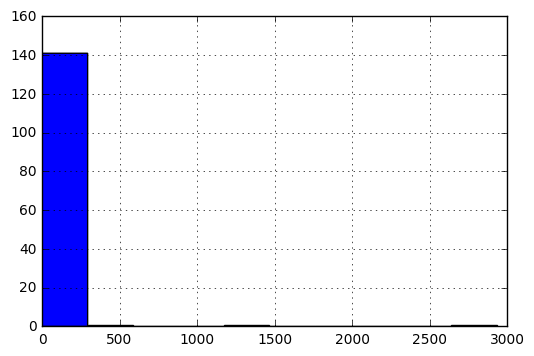

In [28]:
unique_contributors.contributions.hist()

In [29]:
def rank_by_contributors(table, field):
    grouped = table.groupby(field, as_index=False)
    summed = grouped.login.count()
    summed.columns = [field, 'count']
    return summed

In [30]:
def rank_by_contributions(table, field):
    grouped = table.groupby(field, as_index=False)
    return grouped.contributions.sum()

In [31]:
def create_ranking(table, field):
    count = rank_by_contributors(table, field)
    summed = rank_by_contributions(table, field)
    merged = count.merge(summed)
    merged['count_percent'] = merged['count'] / total_contributors
    merged['contributions_percent'] = merged['contributions'] / total_contributions
    return merged.sort_values("contributions", ascending=False)

In [32]:
create_ranking(unique_contributors, 'name')[['name', 'contributions', 'contributions_percent']].head(20)

,name,contributions,contributions_percent
18,Ben Welsh,2932,0.541359
58,James Gordon,1329,0.245384
0,Aaron Williams,379,0.069978
115,Sahil Chinoy,126,0.023264
1,Agustin Armendariz,69,0.012740
20,Bill Chambers,47,0.008678
13,Anthony Pesce,40,0.007386
24,Casey Miller,33,0.006093
70,Juan Elosua,29,0.005355
86,Luciana Godoy,25,0.004616


In [33]:
create_ranking(unique_contributors, 'company').head(20)

,company,count,contributions,count_percent,contributions_percent
42,Los Angeles Times,16,3016,0.111111,0.556869
14,California Civic Data Coalition,1,1329,0.006944,0.245384
78,Washington Post,3,387,0.020833,0.071455
69,UC Berkeley,1,126,0.006944,0.023264
49,New York Times,4,73,0.027778,0.013479
44,Mozilla OpenNews,7,47,0.048611,0.008678
22,Databricks,1,47,0.006944,0.008678
76,Vox Media,2,36,0.013889,0.006647
46,NPR,1,29,0.006944,0.005355
70,UC San Diego,1,20,0.006944,0.003693


In [34]:
create_ranking(unique_contributors, 'location').head(20)

,location,count,contributions,count_percent,contributions_percent
25,"Los Angeles, CA",19,3023,0.131944,0.558161
11,"Columbia, MO",3,1331,0.020833,0.245753
47,"Washington, DC",15,428,0.104167,0.079025
4,"Berkeley, CA",4,176,0.027778,0.032496
28,"New York, NY",19,167,0.131944,0.030835
10,"Chicago, IL",6,31,0.041667,0.005724
7,"Buenos Aires, Argentina",5,30,0.034722,0.005539
37,"San Francisco, CA",8,27,0.055556,0.004985
36,"San Diego, CA",1,20,0.006944,0.003693
3,"Austin, TX",4,15,0.027778,0.002770


In [35]:
create_ranking(unique_contributors, 'in_coalition').head(20)

,in_coalition,count,contributions,count_percent,contributions_percent
1,True,7,4847,0.048611,0.894941
0,False,137,569,0.951389,0.105059


In [36]:
create_ranking(unique_contributors, 'in_california').head(20)

,in_california,count,contributions,count_percent,contributions_percent
1,True,41,3271,0.284722,0.603951
0,False,103,2145,0.715278,0.396049


In [37]:
create_ranking(unique_contributors, 'in_usa').head(20)

,in_usa,count,contributions,count_percent,contributions_percent
1,True,114,5325,0.791667,0.983198
0,False,15,52,0.104167,0.009601


In [38]:
create_ranking(unique_contributors, 'state').head(20)

,state,count,contributions,count_percent,contributions_percent
1,CA,41,3271,0.284722,0.603951
9,MO,4,1332,0.027778,0.245938
2,DC,15,428,0.104167,0.079025
12,NY,19,167,0.131944,0.030835
6,IL,9,38,0.062500,0.007016
16,TX,7,19,0.048611,0.003508
10,NE,1,12,0.006944,0.002216
19,WA,2,9,0.013889,0.001662
3,FL,1,9,0.006944,0.001662
13,OH,1,7,0.006944,0.001292


In [39]:
create_ranking(unique_contributors, 'country').head(20)

,country,count,contributions,count_percent,contributions_percent
9,United States of America,114,5325,0.791667,0.983198
0,Argentina,5,30,0.034722,0.005539
8,Rwanda,1,11,0.006944,0.002031
4,Czech Republic,1,9,0.006944,0.001662
7,Norway,4,4,0.027778,0.000739
1,Brazil,1,2,0.006944,0.000369
2,Canada,1,2,0.006944,0.000369
3,Chile,1,1,0.006944,0.000185
5,Denmark,1,1,0.006944,0.000185
6,Germany,1,1,0.006944,0.000185
